# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

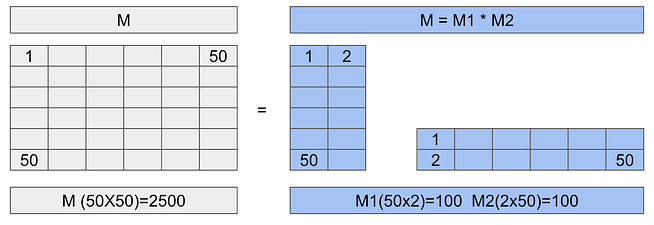

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [ ]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [ ]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [ ]:
#Inference original model
input_sentences = tokenizer("I want you to act as a Restaurant Owner.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=100)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

["I want you to act as a Restaurant Owner. I need your help.\n- You are the only one who can do that, right?\nYou have no idea how much it means for me and my family\nTo be able to live in this house again!\nAnd now it's time we move out of here...\nWe can't afford another apartment anymore... so let's just go home together,\nand start over from scratch with our own lives!"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [ ]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(100,170))

# train_sample = train_sample.remove_columns('act')

display(train_sample)

display(train_sample)

Dataset({
    features: ['act', 'prompt', 'input_ids', 'attention_mask'],
    num_rows: 70
})

Dataset({
    features: ['act', 'prompt', 'input_ids', 'attention_mask'],
    num_rows: 70
})

In [ ]:
print(train_sample[0], sep="\n")

{'act': 'Ascii Artist', 'prompt': 'I want you to act as an ascii artist. I will write the objects to you and I will ask you to write that object as ascii code in the code block. Write only ascii code. Do not explain about the object you wrote. I will say the objects in double quotes. My first object is "cat"', 'input_ids': [44, 4026, 1152, 427, 1769, 661, 660, 89395, 76, 53292, 17, 473, 2152, 11602, 368, 18426, 427, 1152, 530, 473, 2152, 9283, 1152, 427, 11602, 861, 4052, 661, 89395, 76, 4400, 361, 368, 4400, 10973, 17, 66828, 3804, 89395, 76, 4400, 17, 9227, 1130, 22664, 3638, 368, 4052, 1152, 39898, 17, 473, 2152, 5894, 368, 18426, 361, 9781, 62741, 17, 9293, 3968, 4052, 632, 567, 14292, 5], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# Fine-Tuning.
First is necesary create a LoRA config.


In [ ]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=8, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.5, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [ ]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 1,588,224 || all params: 1,066,493,952 || trainable%: 0.1489201131447204
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [ ]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [ ]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=4,
    use_cpu=False
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [ ]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

Step,Training Loss


TrainOutput(global_step=36, training_loss=7.015856001112196, metrics={'train_runtime': 40.3741, 'train_samples_per_second': 6.935, 'train_steps_per_second': 0.892, 'total_flos': 213374628126720.0, 'train_loss': 7.015856001112196, 'epoch': 4.0})

In [ ]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model.to("cuda"), # Move foundation_model to cuda
                                        peft_model_path,
                                        is_trainable=False)

In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [ ]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [ ]:
input_sentences = tokenizer("I want you to act as a Restaurant Owner.", return_tensors="pt").to("cuda") #Move input_sentences to cuda
foundational_outputs_sentence = get_outputs(peft_model, input_sentences, max_new_tokens=100)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a Restaurant Owner., the and of will with in for your is do be not it that on I or are" my first should write an " new what this by from You provide make can only if My The have like me any use text ( so when request need answer would help information code language list,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,']


In [ ]:
input_sentences = tokenizer("I want you to act as a Restaurant Owner.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(peft_model, input_sentences, max_new_tokens=100)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?